In [2]:
def clean_text(str_in):
    import re
    tmp = re.sub("[^A-Za-z'0-9]+", " ",str_in).lower().strip().replace("  ", " ")
    return tmp

def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    sw.remove('no')
    sw.remove('not')
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o


def clean_text(str_in):
    import re
    tmp = re.sub("[^A-Za-z'0-9]+", " ",str_in).lower().strip().replace("  ", " ")
    return tmp

def file_clean(path_in):
    f = open(path_in, encoding="UTF-8")
    tmp = f.read()
    f.close()
    tmp = clean_text(tmp)
    return tmp

def read_files(path_in):
    import os
    import pandas as pd
    file_list = pd.DataFrame()
    for root, dirs, files in os.walk(path_in, topdown=False):
        for name in files:
            try:
                t_path = root + "/" + name
                file_p = file_clean(t_path)
                t_p = root.split("/")[-1:][0]
                if len(file_p) > 0:
                    file_list = file_list.append(
                        {"body": file_p, "label": t_p
                         }, ignore_index=True)
            except:
                print (t_path)
                pass
    return file_list

def wrd_dictionary(df_in, col_name_in):
    import collections
    my_dictionaty_t = dict()
    for topic_t in df_in.label.unique():
        tmp = df_in[df_in.label == topic_t]
        tmp = tmp[col_name_in].str.cat(sep=" ")
        wrd_freq = collections.Counter(tmp.split())
        my_dictionaty_t[topic_t] = wrd_freq
    return my_dictionaty_t

def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o

def write_pickle(obj_in, path_in, name_in):
    import pickle
    pickle.dump(obj_in, open(path_in + name_in + ".pk", 'wb'))
    

def read_pickle(path_in, name_in):
    import pickle
    the_data_t = pickle.load(open(path_in + name_in + ".pk", 'rb'))
    return the_data_t

def wrd_cnt(txt_in):
    tmp = len(set(txt_in.split()))
    return tmp

def stem_fun(txt_in):
    from nltk.stem import PorterStemmer
    stem_tmp = PorterStemmer()
    tmp = [stem_tmp.stem(word) for word in txt_in.split()]
    tmp = ' '.join(tmp)
    # tmp = list()
    # for word in txt_in.split():
    #     tmp.append(stem_tmp.stem(word))
    return tmp

def bag_of_words(texts):
    word_count = {}
    for text in texts:
        for word in text.split():
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
  
    df = pd.DataFrame.from_dict(word_count, orient='index', columns=['frequency'])
    df.sort_values(by='frequency', ascending=False, inplace=True)
    return df

In [3]:
import pandas as pd
import numpy as np
import os
from top2vec import Top2Vec

In [232]:
#Reading in database
opinions = pd.read_csv('/Users/mjs/Downloads/archive/all_opinions.csv')
docs = opinions.text[opinions['author_name'] == 'Justice Thomas'].tolist()

In [231]:
print(len(docs))

551


In [233]:
import matplotlib.pyplot as plt
author_name_counts = opinions['author_name'].value_counts()

labels = []
sizes = []

for name, count in author_name_counts.iteritems():
    if count < 500:
        labels.append("Other")
        sizes.append(count)
    else:
        labels.append(name)
        sizes.append(count)

pie = pd.concat([pd.DataFrame(labels, columns = ['name']),pd.DataFrame(sizes, columns = ['count'])], axis =1)
# pie = pie.groupby('name').sum()
# pie = pie.reset_index()

import plotly.express as px

fig = px.pie(pie, values='count', names='name')
fig.show()

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim

In [240]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)
    
lem_text = lemmatization(docs)

In [241]:
def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    sw.extend(['see','file','hold','use','only','also','other','make','I'])
    sw.remove('no')
    sw.remove('not')
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o 

docs_clean = [rem_sw(text) for text in lem_text]

In [242]:
bag_of_words(docs_clean)[0:10]

,frequency
court,6774
law,5966
state,5879
case,5645
claim,4376
right,3604
federal,3548
statute,3357
supra,2795
rule,2791


In [243]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return final
    
data_words = gen_words(lem_text)

In [244]:
#Bigrams and Trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count = 5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigram(texts):
    return(bigram[doc] for doc in texts)

def make_trigram(texts):
    return(trigram[bigram[doc]] for doc in texts)

data_bigrams = make_bigram(data_words)
data_bigrams_trigrams = make_trigram(data_bigrams)

In [245]:
data_bigrams_trigrams_list = []
for phrase in data_bigrams_trigrams:
    data_bigrams_trigrams_list.append(phrase)

In [246]:
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_bigrams_trigrams_list)
texts = data_bigrams_trigrams_list
corpus = [id2word.doc2bow(text) for text in texts]

In [247]:
## making a list-of-strings version for count vectorizer
str_corpus = [' '.join(text) for text in texts]

In [248]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(str_corpus).toarray()

In [249]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# create df of words and show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,aa,aardvark,ab,abandon,abandonment,abate,abbreviate,abbreviation,abc,abdi,...,zipper,zling,zon,zone,zone_code,zone_danger,zone_danger_test,zoning,zure,zurek
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, max_iter=50, random_state=0)
doc_topic_matrix = lda.fit_transform(cv_matrix)

CPU times: user 55.8 s, sys: 3.76 s, total: 59.6 s
Wall time: 30.4 s


In [251]:
## doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 
                                                       'T9', 'T10'])
doc_topic_df

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.000168,0.000168,0.212620,0.491839,0.000168,0.048790,0.079026,0.051080,0.115975,0.000168
1,0.007694,0.007693,0.007694,0.462414,0.007693,0.007693,0.007694,0.007694,0.007693,0.476038
2,0.692832,0.000232,0.000232,0.099472,0.000232,0.000232,0.000232,0.000232,0.000232,0.206075
3,0.307945,0.000357,0.000357,0.000357,0.000357,0.000357,0.082154,0.607401,0.000357,0.000357
4,0.084585,0.000048,0.000048,0.134170,0.152247,0.059097,0.556398,0.000048,0.000048,0.013310
...,...,...,...,...,...,...,...,...,...,...
546,0.690250,0.000045,0.072601,0.222556,0.000045,0.000045,0.000045,0.000045,0.014324,0.000045
547,0.000058,0.240786,0.000058,0.000058,0.000058,0.000058,0.228079,0.453063,0.000058,0.077722
548,0.000097,0.000097,0.000097,0.097487,0.001760,0.000097,0.366539,0.000097,0.465679,0.068049
549,0.401923,0.000087,0.149794,0.000087,0.000087,0.037097,0.000087,0.000087,0.037932,0.372817


In [252]:
## extract topics
topic_word_matrix = lda.components_

pd.DataFrame(topic_word_matrix, columns=vocab)

,aa,aardvark,ab,abandon,abandonment,abate,abbreviate,abbreviation,abc,abdi,...,zipper,zling,zon,zone,zone_code,zone_danger,zone_danger_test,zoning,zure,zurek
0,4.099960,0.100001,6.339847,31.516366,1.201746,0.100000,3.099888,0.100000,0.100000,1.099890,...,2.099948,0.100013,0.100000,0.100015,0.100000,0.100003,0.100003,0.100002,1.099744,0.1
1,0.100000,0.100000,0.100089,10.573047,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,1.099987,0.100000,4.976094,0.100000,0.100000,0.100000,0.100031,0.100050,0.1
2,0.100000,0.100000,0.100031,3.976498,0.100083,0.100070,0.100041,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,4.066852,0.100000,6.099977,21.099978,1.415001,0.100056,0.1
3,0.100007,0.100001,2.383984,35.688537,0.100098,0.100046,0.100000,0.100100,0.100005,0.100090,...,0.100034,0.100000,0.100000,0.100097,0.100002,0.100000,0.100000,0.100033,0.100079,3.1
4,0.100004,0.100000,0.100019,0.100020,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100001,0.100003,0.100000,0.100000,0.100000,0.100011,0.100030,0.1
5,0.100000,0.100008,0.100000,0.100033,0.100050,3.099696,0.100011,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100011,0.100000,0.100000,0.100000,0.100005,0.100004,0.1
6,0.100009,1.099971,2.136789,6.144995,0.100092,0.100021,0.100014,0.100028,0.100000,0.100010,...,0.100018,0.100000,0.100000,19.436275,10.099998,0.100003,0.100003,2.784899,0.100000,0.1
7,0.100000,0.100005,1.539191,17.797669,5.997854,0.100039,0.100008,1.099872,0.100004,0.100000,...,0.100000,0.100000,0.100000,0.100017,0.100000,0.100000,0.100000,0.100000,0.100012,0.1
8,0.100000,0.100013,0.100002,2.002812,1.099922,0.100130,0.100004,0.100000,1.099992,0.100009,...,0.100000,0.100000,0.100000,7.920600,0.100000,0.100000,0.100000,0.100000,0.100024,0.1
9,0.100020,0.100000,0.100046,0.100022,0.100154,0.100000,0.100034,0.100000,0.100000,0.100000,...,0.100000,0.100000,1.099999,0.100037,0.100000,0.100017,0.100016,0.100017,0.100000,0.1


In [255]:
## This function sorts the words importances under each topic
## and the selectional criteria include (a) ranks based on weights, or (b) cutoff on weights
def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    for i, topic_weights in enumerate(tw_m):  ## for each topic row
        topic = [(token, np.round(weight, 2))
                 for token, weight in zip(vocab, topic_weights)
                 ]  ## zip (word, importance_weight)
        topic = sorted(topic,
                       key=lambda x: -x[1])  ## rank words according to weights
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff
                     ]  ## output words whose weights > 0.6
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

In [254]:
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=False,
                    topn=7)

Topic #0 :
court see claim case state federal trial
Topic #1 :
court rule case state see petitioner right
Topic #2 :
officer see case law conduct know claim
Topic #3 :
see right power law court dissent case
Topic #4 :
plan property debtor claim benefit interest exemption
Topic #5 :
tax see state case use taxis water
Topic #6 :
state statute law see provide federal provision
Topic #7 :
see sentence offense law case crime defendant
Topic #8 :
see school child government state officer power
Topic #9 :
action claim plaintiff employee patent see suit


Based off of the most relevent words for each topic, we can subjectively create topic titles that try to summarize the idea of that topic. Then, we can assign each appeals document to a topic, whatever is most dominant in that document.
Topic 1 (0) looks like it's about _claims_.
Topic 2 looks like it's about _petitioning rules_.
Topic 3 looks like it's about _officer conduct_.
Topic 4 looks like it's about _power to dissent_.
Topic 5 looks like it's about _property_.
Topic 6 looks like it's about _tax_.
Topic 7 looks like it's about _state statutes_.
Topic 8 looks like it's about _criminal sentencing_.
Topic 9 looks like it's about _education_.
Topic 10 looks like it's about _employment_.

In [257]:
topics = ['claims', 'petitioning_rules', 'officer_conduct', 'dissent', 'property', 'tax', 'state_statutes', 'criminal_sentencing', 'education', 'employment']
doc_topic_df.columns = topics
doc_topic_df['corpus'] = str_corpus
doc_topic_df

,claims,petitioning_rules,officer_conduct,dissent,property,tax,state_statutes,criminal_sentencing,education,employment,corpus
0,0.000168,0.000168,0.212620,0.491839,0.000168,0.048790,0.079026,0.051080,0.115975,0.000168,adhere_view decision curiam denigrate core spe...
1,0.007694,0.007693,0.007694,0.462414,0.007693,0.007693,0.007694,0.007694,0.007693,0.476038,concur stress sexual_harassment case plaintiff...
2,0.692832,0.000232,0.000232,0.099472,0.000232,0.000232,0.000232,0.000232,0.000232,0.206075,agree lack jurisdiction respondent appeal grou...
3,0.307945,0.000357,0.000357,0.000357,0.000357,0.000357,0.082154,0.607401,0.000357,0.000357,continue disagree remedy fashion post booker s...
4,0.084585,0.000048,0.000048,0.134170,0.152247,0.059097,0.556398,0.000048,0.000048,0.013310,provide stamp_tax_exemption asset transfer pla...
...,...,...,...,...,...,...,...,...,...,...,...
546,0.690250,0.000045,0.072601,0.222556,0.000045,0.000045,0.000045,0.000045,0.014324,0.000045,join_opinion correctly conclude respondent arg...
547,0.000058,0.240786,0.000058,0.000058,0.000058,0.000058,0.228079,0.453063,0.000058,0.077722,case consider incumbent pro vider local_teleph...
548,0.000097,0.000097,0.000097,0.097487,0.001760,0.000097,0.366539,0.000097,0.465679,0.068049,never find state action base mere entwinement ...
549,0.401923,0.000087,0.149794,0.000087,0.000087,0.037097,0.000087,0.000087,0.037932,0.372817,decide today civil right plaintiff receive nom...


Now, we can use this dataframe to see how much each topic relates to each corpus. It looks like one or two topics dominate for each corpus. We can infer the meaning of the courpus from this method.

Since PyLDAvis no longer has a visualization method for SKLearn, let's conduct a tfidf via gensim and see how our results change. Perhaps we'll occur more distinct, relevent topics.

In [276]:
id2word = corpora.Dictionary(data_bigrams_trigrams_list)
texts = data_bigrams_trigrams_list
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids=[id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value<low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops: 
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 6), (15, 4), (16, 1), (17, 2), (18, 1), (19, 1)]


In [277]:
## for elbow graph
topics = [*range(1, 36)]

In [278]:
# chosing number of topics based on coherency score
from gensim.models.coherencemodel import CoherenceModel

scores = []
for i in range(1, 36):
    test_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = i,
                                            update_every = 1,
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=test_model, 
                                         texts=texts,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)
    scores.append(coherence_lda)


Coherence Score:  0.24148344663054672
Coherence Score:  0.27170565122959484
Coherence Score:  0.3038200110457397
Coherence Score:  0.3256859920520953
Coherence Score:  0.33466966870133524
Coherence Score:  0.3271639461067517
Coherence Score:  0.35642829465234305
Coherence Score:  0.36848205806530965
Coherence Score:  0.39535869067606855
Coherence Score:  0.37192524739309685
Coherence Score:  0.3536032711500892
Coherence Score:  0.3596760415992728
Coherence Score:  0.38664042707103036
Coherence Score:  0.35486024630007185
Coherence Score:  0.3880418571146024
Coherence Score:  0.37274407605392257
Coherence Score:  0.4052286085970409
Coherence Score:  0.3983300277663715
Coherence Score:  0.3918940439338369
Coherence Score:  0.40302066907659845
Coherence Score:  0.38151546354605614
Coherence Score:  0.38731527905428176
Coherence Score:  0.40534766579384046
Coherence Score:  0.3892350602758236
Coherence Score:  0.39004557618715263
Coherence Score:  0.39292341576904016
Coherence Score:  0.39

<function matplotlib.pyplot.show(close=None, block=None)>

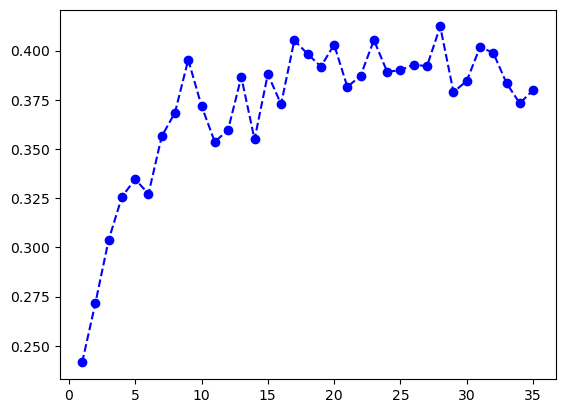

In [279]:
plt.plot(topics, scores, 'bo', linestyle='dashed')
plt.show

Start to lose meaning/overfit at around n=10 topics. Let's go with 10.

In [280]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 10,
                                            update_every = 1,
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")

In [281]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmda", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.109826 -0.135402       1        1  15.787795
2      0.116954  0.032801       2        1  12.923995
3      0.206501  0.053969       3        1  11.585839
4     -0.006877  0.239799       4        1  11.114476
5     -0.168237  0.192249       5        1   9.847274
1     -0.138174 -0.164083       6        1   9.603332
8     -0.077567  0.043493       7        1   9.570269
9     -0.207593 -0.042401       8        1   8.153774
7      0.218544 -0.022004       9        1   6.976335
0     -0.053376 -0.198419      10        1   4.436911, topic_info=             Term         Freq        Total Category  logprob  loglift
174           law  2253.000000  2253.000000  Default  30.0000  30.0000
1126        state  2531.000000  2531.000000  Default  29.0000  29.0000
285         right  1816.000000  1816.000000  Default  28.0000  28.0000
434       federal  2380.000000  2380.000000  Default  27.0000  27.0000
289          rule   998.000000   998.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
483    petitioner   224.803339  1629.495203  Topic10  -3.9050   1.1344
636    reasonable    84.432445   215.542556  Topic10  -4.8843   2.1780
2127  prosecution    65.190549   224.579486  Topic10  -5.1429   1.8783
2274  enforcement    58.037391   201.512717  Topic10  -5.2591   1.8704
778       conduct    59.111926   258.938224  Topic10  -5.2408   1.6381

[597 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2210      1  0.189402  access
2210      6  0.017756  access
2210      7  0.793119  access
5053      1  0.990644  accuse
3         3  0.132409     act
...     ...       ...     ...
2574      6  0.986728  worker
2574      8  0.014511  worker
3006      1  0.044495    writ
3006      3  0.949236    writ
6651      9  0.966570   young

[993 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 5, 6, 2, 9, 10, 8, 1])

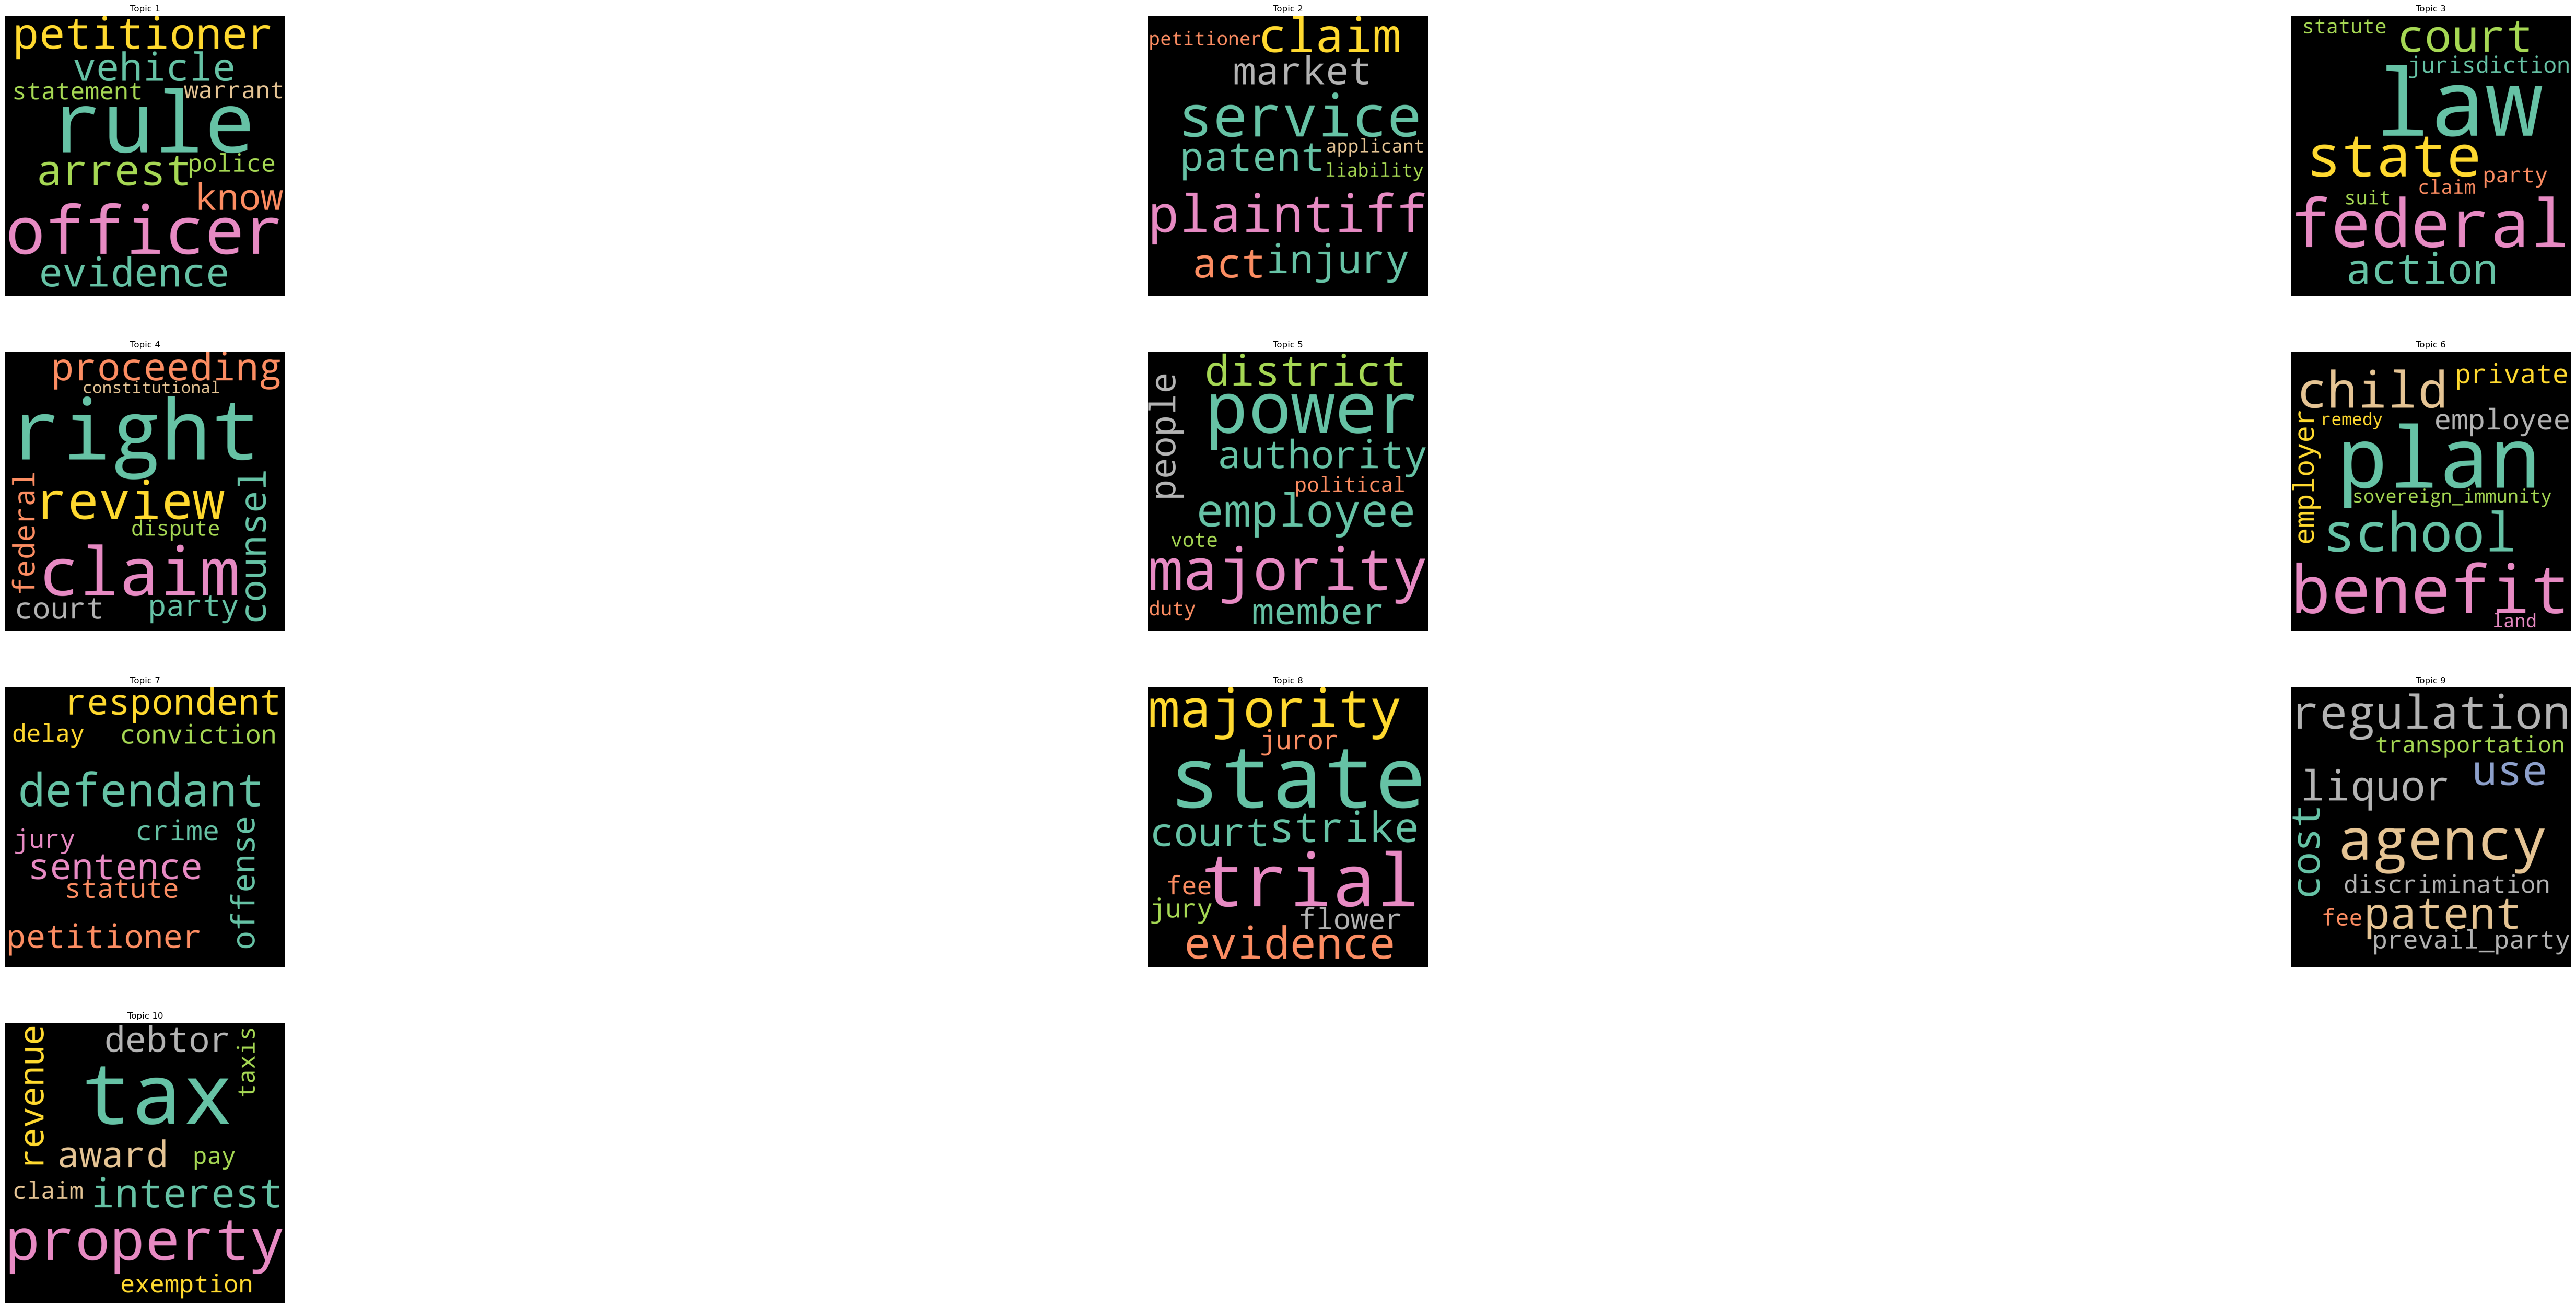

In [282]:
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
fig = plt.figure(figsize=(80,32))
for t in range(lda_model.num_topics):
    ax = fig.add_subplot(4,3,t+1)
    wc = WordCloud(width=2500, 
                   height=2500, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).fit_words(dict(lda_model.show_topic(t)))
    ax.imshow(wc)
    ax.set_title('Topic ' + str(t+1))
    ax.axis("off");